In [1]:
# Import Requried Libaries
import os
import cv2
import imageio
import torch
import torchvision
import albumentations as A
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import optim
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from scipy.signal import find_peaks
from glob import glob
from PIL import Image
import warnings

warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

torch.__version__

'1.9.0+cu102'

In [2]:
from torchvision import models

In [3]:
torch.cuda.is_available()

True

In [ ]:
# !unzip /content/drive/MyDrive/Data/data.zip -d data/

In [4]:
t = transforms.Compose([
            transforms.RandomVerticalFlip(),
            transforms.GaussianBlur(3, 0.1),
            transforms.RandomAutocontrast(0.1),
            transforms.ToTensor(),
            transforms.RandomRotation(2),
            transforms.Grayscale(1),
        ])

In [5]:
ds = ImageFolder("data", transform=t)
print(f"Length: {len(ds)}")

Length: 3500


In [6]:
ds.class_to_idx

{'mild': 0, 'moderate': 1, 'no_dr': 2, 'proliferative_dr': 3, 'severe': 4}

In [7]:
train_idx, test_idx = train_test_split([*range(len(ds))], test_size=0.2)

In [8]:
train_loader = DataLoader(ds, 128, False, SubsetRandomSampler(train_idx))
test_loader = DataLoader(ds, 32, False, SubsetRandomSampler(test_idx))

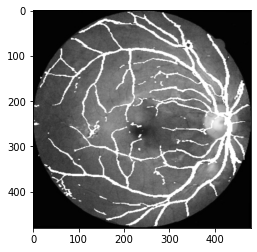

In [9]:
sample = next(iter(train_loader))
plt.imshow(sample[0][0].squeeze().numpy(), cmap="binary_r");

In [10]:
class BaseConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride):
        super(BaseConv, self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, kernel_size, stride, 1)
        self.act = nn.ReLU()
            
    def forward(self, x):
        x = self.act(self.conv(x))
        return x    
    
class MaxPool(nn.Module):
    def __init__(self, kernel_size, stride):
        super(MaxPool, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size, stride, 1)
        
    def forward(self, x):
        return self.maxpool(x)

In [11]:
class CNN(nn.Module):
    def __init__(self, in_channel):
        super(CNN, self).__init__()
        self.conv1 = BaseConv(1, 32, 5, 2)
        self.conv2 = BaseConv(32, 64, 3, 2)
        self.conv3 = BaseConv(64, 64, 5, 2)
        self.conv4 = BaseConv(64, 64, 3, 2)
        self.conv5 = BaseConv(64, 128, 3, 2)
        self.conv6 = BaseConv(128, 128, 5, 2)
        self.conv7 = BaseConv(128, 128, 3, 2)
        self.conv8 = BaseConv(128, 256, 3, 2)
        self.conv9 = BaseConv(256, 256, 3, 2)
        self.conv10 = BaseConv(256, 512, 3, 2)
        self.conv11 = BaseConv(512 ,512, 3 ,2)
        self.max1 = MaxPool(3, 2)
        self.max2 = MaxPool(5, 2)
        self.feed1 = nn.Linear(512, 1024)
        self.feed2 = nn.Linear(1024, 5)
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.max1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.max1(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = self.max1(x)
        x = self.conv9(x)
        x = self.conv9(x)
        x = self.conv10(x)
        x = self.max1(x)
        x = self.conv11(x)
        x = self.conv11(x)
        x = self.max1(x)
        x = x.view(x.shape[0], -1)
        x = self.feed1(x)
        x = self.feed2(x)
        return x

In [12]:
cnn = CNN(1)
cnn = cnn.to(device="cuda")

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=1e-05)
scheduler = optim.lr_scheduler.StepLR(optimizer, 1, 0.1)

In [14]:
def accuracy(y_pred, y_true):
  _, y_pred = torch.max(torch.log_softmax(y_pred, 1), 1)
  correct_pred = (y_pred == y_true).float()
  acc = correct_pred.sum() / len(correct_pred)
  acc = torch.round(acc * 100)    
  return acc

In [15]:
def train(model, data_loader, optimizer, criterion, device):
  epoch_loss = 0.0
  epoch_acc = 0.0

  model.train()
  for batch in data_loader:

    x = batch[0].to(device)
    y = batch[1].to(device)

    optimizer.zero_grad()
    pred = model(x)
    loss = criterion(pred, y)
    acc = accuracy(pred, y)

    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  epoch_loss = epoch_loss/len(data_loader)
  epoch_acc = epoch_acc/len(data_loader)

  return epoch_loss, epoch_acc

In [16]:
def evaluate(model, data_loader, criterion, device):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.eval()
    with torch.no_grad():
      for batch in data_loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        pred = model(x)
        loss = criterion(pred, y)
        acc = accuracy(pred, y)

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    epoch_loss = epoch_loss/len(data_loader)
    epoch_acc = epoch_acc/len(data_loader)

    return epoch_loss, epoch_acc

In [17]:
checkpoint_path = "CNN.pth"

In [ ]:
best_valid_loss = float("inf")

for epoch in range(50):
  train_loss, train_acc = train(cnn, train_loader, optimizer, criterion, "cuda")
  test_loss, test_acc = evaluate(cnn, test_loader, criterion, "cuda")

  """ Saving the model """
  if test_loss < best_valid_loss:
      data_str = f"Valid loss improved from {best_valid_loss:2.4f} to {test_loss:2.4f}"
      print(data_str)

      best_valid_loss = test_loss
      torch.save(cnn.state_dict(), checkpoint_path)

  print(f"Epoch: {epoch + 1} TrainLoss: {train_loss: .3f} TrainAcc: {train_acc: .3f} TestLoss: {test_loss: .3f} TestAcc: {test_acc: .3f}")